<a href="https://colab.research.google.com/github/gtoubassi/active-learning-mnist/blob/master/Active_Learning_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Learning with MNIST

The following is a simple example of the benefits of active learning.  When you have lots of data, but labeling costs are high, you want to choose wisely which data to label.  i.e. Label the first 1,000 items, train a model, then use that model to pick what 1,000 items to label next.  Using the model to pick which samples to label next can be more efficient then just randomly labeling more data.  The intuition behind this is that you want to select samples that are closest to the decision boundary, as they are likey to impact accuracy most, whereas samples far from the decision boundary probably will not change accuracy.  How do we prioritize different samples to label?  There are a few options demonstrated below, but the simplest and most intuitive is to simply pick the item which have the lowest confidence prediction from the existing model (i.e. the samples that the model is most unsure about).

In the below notebook we train MNIST by starting with 500 labels, and then prioritize each incremental 500 labeled samples based on how the current model views them (e.g. choose the 500 that have the lowest confidence prediction).  We compare to a simple baseline where we  randomly add items at each iteration.  The baseline gives a sense for how much the model benefits from additional data.

### References
https://www.datacamp.com/community/tutorials/active-learning

## Install and import dependencies

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
!pip install -q tensorflow==2.0.0-beta1

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


## Load MNIST Data

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Define Function for Evaluating Labeling Prioritization Schemes
This function evaluates test accuracy after training on 500 items, then 1,000, then 1,500, etc up to 20,000 items.  At each iteration it decides what 500 items to add to the training set based on the prioritizer.  The prioritizer is given the predictions made by the model on the remaining samples so it can decide which ones are most productive to train on.


In [0]:
def eval_prioritization_strategy(prioritizer):
  train_indices = range(60000)

  test_accuracies = []
  x_train_subset = np.zeros([0, 28, 28])
  y_train_subset = np.empty([0,])

  for i in range(40):
    selected_indices = train_indices[0:500]
    train_indices = train_indices[500:]
    x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
    y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0)
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    test_accuracies.append(accuracy)
    print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

    predictions = model.predict(x_train[train_indices,...])
    train_indices = prioritizer(train_indices, predictions)

  return test_accuracies


## Baseline
As a baseline lets just add more items to the training set without regard for how the current model fares.  This gives a sense for how quickly the model improves merely by adding unpreferential labeled data.  Its interesting to note on how little data the model needs for the MNIST dataset (e.g. 90% accuracy at 2,000 samples -- it takes the next 58,000 samples to get to 97.5%)

In [4]:
unprioritized_accuracies = eval_prioritization_strategy(lambda indices, pred: indices)

W0619 12:41:26.357182 139777633695616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training data size of 500 => accuracy 0.823700
Training data size of 1000 => accuracy 0.867300
Training data size of 1500 => accuracy 0.889800
Training data size of 2000 => accuracy 0.901400
Training data size of 2500 => accuracy 0.897400
Training data size of 3000 => accuracy 0.902200
Training data size of 3500 => accuracy 0.922500
Training data size of 4000 => accuracy 0.921600
Training data size of 4500 => accuracy 0.923100
Training data size of 5000 => accuracy 0.926700
Training data size of 5500 => accuracy 0.931800
Training data size of 6000 => accuracy 0.931100
Training data size of 6500 => accuracy 0.935100
Training data size of 7000 => accuracy 0.931800
Training data size of 7500 => accuracy 0.938500
Training data size of 8000 => accuracy 0.937900
Training data size of 8500 => accuracy 0.936000
Training data size of 9000 => accuracy 0.938900
Training data size of 9500 => accuracy 0.938400
Training data size of 10000 => accuracy 0.944100
Training data size of 10500 => accuracy 

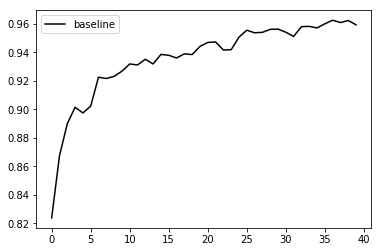

In [5]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.legend()

## Prioritize "least confidence"
Now lets prioritize adding data that the model is most unsure about, in the hopes that it will more rapidly improve the models test accuracy.  "unsure" in this context are those items with the lowest maximum logit (meaning its prediction is weak).

In [0]:
def least_confidence_prediction_prioritizer(indices, predictions):
  max_logit = list(zip(indices, np.amax(predictions,axis=1)))
  max_logit.sort(key=lambda x: x[1]) # sort in ascending order
  return list(zip(*max_logit))[0]

In [7]:
least_confidence_accuracies = eval_prioritization_strategy(least_confidence_prediction_prioritizer)

Training data size of 500 => accuracy 0.823600
Training data size of 1000 => accuracy 0.872000
Training data size of 1500 => accuracy 0.890600
Training data size of 2000 => accuracy 0.914200
Training data size of 2500 => accuracy 0.922400
Training data size of 3000 => accuracy 0.937400
Training data size of 3500 => accuracy 0.947300
Training data size of 4000 => accuracy 0.951600
Training data size of 4500 => accuracy 0.953500
Training data size of 5000 => accuracy 0.960600
Training data size of 5500 => accuracy 0.962000
Training data size of 6000 => accuracy 0.965400
Training data size of 6500 => accuracy 0.970100
Training data size of 7000 => accuracy 0.966200
Training data size of 7500 => accuracy 0.970100
Training data size of 8000 => accuracy 0.970300
Training data size of 8500 => accuracy 0.971800
Training data size of 9000 => accuracy 0.972200
Training data size of 9500 => accuracy 0.972600
Training data size of 10000 => accuracy 0.973300
Training data size of 10500 => accuracy 

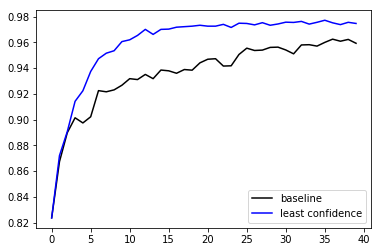

In [8]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.legend()

## Prioritize "highest entropy" of the resulting softmax
Lets try a different measure of what to prioritize.  Lets pick the predictions which have the highest entropy of the resulting softmax.  Meaning the model is most "evenly confused" across all categories.  e.g. a prediction of [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1] would be the most desirable candidate to add.

In [0]:
def entropy_prioritizer(indices, predictions):
  p = predictions * np.log(predictions)
  p = -p.sum(axis=1)
  p = list(zip(indices, p))
  p.sort(reverse=True, key=lambda x : x[1]) # sort in descending order
  return list(zip(*p))[0]


In [13]:
entropy_prioritized_accuracies = eval_prioritization_strategy(entropy_prioritizer)

Training data size of 7000 => accuracy 0.966000
Training data size of 7500 => accuracy 0.970700
Training data size of 8000 => accuracy 0.967600
Training data size of 8500 => accuracy 0.970700
Training data size of 9000 => accuracy 0.971600
Training data size of 9500 => accuracy 0.969100
Training data size of 10000 => accuracy 0.969100
Training data size of 10500 => accuracy 0.971300
Training data size of 11000 => accuracy 0.971700
Training data size of 11500 => accuracy 0.973000
Training data size of 12000 => accuracy 0.972900
Training data size of 12500 => accuracy 0.974700
Training data size of 13000 => accuracy 0.971500
Training data size of 13500 => accuracy 0.976100
Training data size of 14000 => accuracy 0.975200
Training data size of 14500 => accuracy 0.976200
Training data size of 15000 => accuracy 0.973600
Training data size of 15500 => accuracy 0.973100
Training data size of 16000 => accuracy 0.977300
Training data size of 16500 => accuracy 0.974700
Training data size of 1700

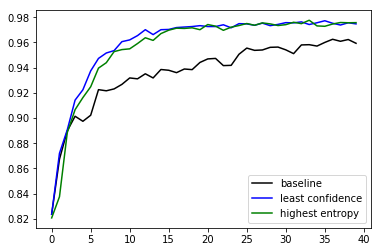

In [14]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.legend()

## Prioritize "least margin"
Another way to prioritize is look for instances where the first and second choice are very close, known as the "margin".

In [0]:
def margin_prioritizer(indices, predictions):
  p = -np.sort(-predictions) # sort in descending order
  p = p[:,0] - p[:,1]
  p = list(zip(indices, p))
  p.sort(key=lambda x : x[1]) # sort in ascending order
  return list(zip(*p))[0]


In [16]:
margin_prioritized_accuracies = eval_prioritization_strategy(margin_prioritizer)

Training data size of 500 => accuracy 0.820900
Training data size of 1000 => accuracy 0.903800
Training data size of 1500 => accuracy 0.894400
Training data size of 2000 => accuracy 0.926800
Training data size of 2500 => accuracy 0.930400
Training data size of 3000 => accuracy 0.947700
Training data size of 3500 => accuracy 0.951000
Training data size of 4000 => accuracy 0.953300
Training data size of 4500 => accuracy 0.959600
Training data size of 5000 => accuracy 0.961300
Training data size of 5500 => accuracy 0.958900
Training data size of 6000 => accuracy 0.966000
Training data size of 6500 => accuracy 0.967500
Training data size of 7000 => accuracy 0.967900
Training data size of 7500 => accuracy 0.970400
Training data size of 8000 => accuracy 0.969400
Training data size of 8500 => accuracy 0.972600
Training data size of 9000 => accuracy 0.972400
Training data size of 9500 => accuracy 0.971200
Training data size of 10000 => accuracy 0.973100
Training data size of 10500 => accuracy 

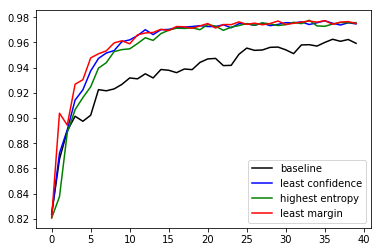

In [17]:
plt.plot(unprioritized_accuracies, 'k', label='baseline')
plt.plot(least_confidence_accuracies, 'b', label='least confidence')
plt.plot(entropy_prioritized_accuracies, 'g', label='highest entropy')
plt.plot(margin_prioritized_accuracies, 'r', label='least margin')
plt.legend()

## Conclusion
Its impressive that with smart selection of which samples to label we can achieve 95% test accuracy on only 3,500 samples, vs without such smart selection it would take 13,000 samples!

Its also interesting to note that the best performing strategy is "least margin", which can be viewed as "highest entropy amongst the top N for N=2".  Would be interesting to try N=3 and see if it performs any better.  Is there something special about N=2?